# Fetch and export SNOTEL sites and daily time series data

In [2]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo
import json
import requests
import rioxarray as rxr

In [3]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################

# DOMAIN
# choose the modeling domain
domain = 'YUKO'


#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# PATHS
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'

# DATES
#start calibration date    
st_dt = '2011-10-01'
#end calibration date
ed_dt = '2018-09-30'

#########################################################################

In [28]:
# functions to get stations as geodataframe
def sites_asgdf(ulmo_getsites, stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=stn_proj
    )
    return sites_gdf

def get_stns(domain):
    
    #path to domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()

    #Snotel bounding box
    Bbox = domains[domain]['Bbox']

    # Snotel projection
    stn_proj = domains[domain]['stn_proj']
    # model projection
    mod_proj = domains[domain]['mod_proj']

    # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
    box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)
    
    # WaterML/WOF WSDL endpoint url 
    #snotel 
    wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

    # get dictionary of snotel sites 
    sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

    #turn sites to geodataframe 
    snotel_gdf = sites_asgdf(sites,stn_proj)
    
    #clip snotel sites to domain bounding box
    gdf1 = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
    gdf1.drop(columns='index_right', inplace=True)
    gdf1.reset_index(drop=True, inplace=True)
    
    #scan (east coast & AK)
    wsdlurl_scan = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    
    # get dictionary of scan sites 
    scan_sites = ulmo.cuahsi.wof.get_sites(wsdlurl_scan,user_cache=True)
    
    #turn sites to geodataframe 
    scan_gdf = sites_asgdf(scan_sites,stn_proj)
    
    #clip scan sites to domain bounding box
    gdf2 = gpd.sjoin(scan_gdf, box_gdf, how="inner")
    gdf2.drop(columns='index_right', inplace=True)
    gdf2.reset_index(drop=True, inplace=True)
    
    # concatenate snotel and scan
    frames = [gdf1, gdf2]
    gdfs = pd.concat(frames)

    #add columns with projected coordinates 
    CSO_proj = gdfs.to_crs(mod_proj)
    gdfs['easting'] = CSO_proj.geometry.x
    gdfs['northing'] = CSO_proj.geometry.y
    gdfs.reset_index(drop=True, inplace=True)
    
    return gdfs

In [29]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    #snotel 
    wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [30]:
def fetch_scan(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    #scan
    wsdlurl = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SCAN:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [31]:
# returns daily timeseries
# https://www.wcc.nrcs.usda.gov/web_service/AWDB_Web_Service_Reference.htm#commonlyUsedElementCodes
# 'WTEQ': swe [in]
# 'SNWD': snow depth [in]
# 'PRCP': precipitation increment [in]
# 'PREC': precipitation accumulation [in]
# 'TAVG': average air temp [F]
# 'TMIN': minimum air temp [F]
# 'TMAX': maximum air temp [F]
# 'TOBS': observered air temp [F]
def get_stn_data(gdf,sd_dt, ed_dt,var,units='metric'):
    '''
    gdf - pandas geodataframe of SNOTEL sites
    st_dt - start date string 'yyyy-mm-dd'
    ed_dt - end date string 'yyyy-mm-dd'
    var - snotel variable of interest 
    units - 'metric' (default) or 'imperial'
    '''
    #empty dataframe for station data
    stn_data = pd.DataFrame(index=pd.date_range(start=st_dt, end=ed_dt))

    for sitecode in gdf.code:
        # get snotel daily data
        if sitecode[-4:] == 'SNTL':
            try:
                data = fetch(sitecode,'SNOTEL:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                stn_data[sitecode] = data.value
            except:
                print('droping '+sitecode)
        # get scan daily data
        if sitecode[-4:] == 'SCAN':
            try:
                data = fetch_scan(sitecode,'SCAN:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                stn_data[sitecode] = data.value
            except:
                print('dropping '+sitecode)
    # grop stations with no data from gdf
    gdffinal = gdf[gdf.code.isin(stn_data.columns)]
    gdffinal.reset_index(drop=True, inplace=True)
    # convert units
    if units == 'metric':
        if (var == 'WTEQ') |(var == 'SNWD') |(var == 'PRCP') |(var == 'PREC'):
            #convert depth units [in] to [m]
            for sitecode in gdffinal.code:
                stn_data[sitecode] = 0.0254 * stn_data[sitecode]
        elif (var == 'TAVG') |(var == 'TMIN') |(var == 'TMAX') |(var == 'TOBS'):
            #convert temp units [F] to [C]
            for sitecode in gdffinal.code:
                stn_data[sitecode] = (stn_data[sitecode] - 32) * 5/9
            # remove missing data
            stn_data[stn_data<-99]=np.nan
    elif units == 'imperial':
        stn_data = stn_data
    return gdffinal, stn_data

In [32]:
def check_stn_bounds(domain,instnGDF):
    #open .tif
    DA = rxr.open_rasterio('/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'+domain+'_dem.tif')
    #get bounds
    bnds = DA.rio.bounds()
    #build bounding box
    box_sgeom = sgeom.box(bnds[0], bnds[1], bnds[2], bnds[3])
    #path to domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()
    # domain projection
    mod_proj = domains[domain]['mod_proj']
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=mod_proj)
    #get geodataframe of all SNOTEL sites in the domain
    stnGDFproj = instnGDF.to_crs(mod_proj)
    #clip snotel sites to domain bounding box
    gdf1 = gpd.sjoin(stnGDFproj, box_gdf, how="inner")
    gdf1.drop(columns='index_right', inplace=True)
    gdf1.reset_index(drop=True, inplace=True)
    return gdf1

YUKO
72
0     1267_AK_SNTL
1     1189_AK_SNTL
2     1062_AK_SNTL
3     1070_AK_SNTL
4      957_AK_SNTL
          ...     
67    2062_AK_SCAN
68    2209_AK_SCAN
69    2063_AK_SCAN
70    2221_AK_SCAN
71    1234_AK_SCAN
Name: code, Length: 72, dtype: object


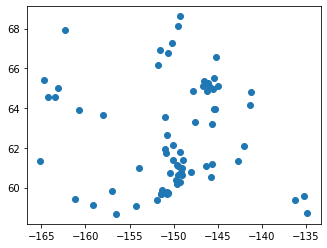

In [24]:
import matplotlib.pyplot as plt
# run all AK domains
domain_list = [domain]

for domain in domain_list:
    print(domain)
    #get geodataframe of all SNOTEL and SCAN sites in the domain
    snotel_gdf = get_stns(domain)
    print(len(snotel_gdf))
    print(snotel_gdf.code)
    if len(snotel_gdf)>0:
        fig, ax = plt.subplots()
        snotel_gdf.plot(ax=ax)

# Execute Functions

In [38]:
#get geodataframe of all SNOTEL and SCAN sites in the domain
stnGDF = get_stns(domain)
#ensure all sites are within domain bounds
stnGDF = check_stn_bounds(domain,stnGDF)

# #get observed temp timeseries 
# domain_gdfT, tob = get_stn_data(stnGDF,st_dt, ed_dt,'TOBS')

# # save geojson
# out = dataPath + 'Station_sites_TOBScelcius_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
# domain_gdfT.to_file(out, driver='GeoJSON')

# #save tobs
# out = dataPath + 'Station_data_TOBScelsius_'+st_dt+'_'+ed_dt+'.csv'
# tob.to_csv(out)

#get precipitation timeseries 
domain_gdfP, pr = get_stn_data(stnGDF,st_dt,ed_dt,'PRCP')

# save geojson
out = dataPath + 'Station_sites_PRmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
domain_gdfP.to_file(out, driver='GeoJSON')

#save pr
out = dataPath + 'Station_data_PRmeters_'+st_dt+'_'+ed_dt+'.csv'
pr.to_csv(out)

#get swe timeseries 
domain_gdfSWE, swe = get_stn_data(stnGDF,st_dt,ed_dt,'WTEQ')

# save geojson
out = dataPath + 'Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
domain_gdfSWE.to_file(out, driver='GeoJSON')

#save swe
out = dataPath + 'Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
swe.to_csv(out)

1267_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1189_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1062_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1070_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
957_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1086_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:PRCP_D
droping 1086_AK_SNTL
1182_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1093_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
958_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
959_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
960_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1071_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1092_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1174_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1268_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1285_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:PRCP_D
droping 1285_AK_SNTL
961_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
962_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
956_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
963_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
964_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1270_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
968_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1091_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:PRCP_D
droping 1091_AK_SNTL
946_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1275_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1036_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:PRCP_D
droping 1036_AK_SNTL
1063_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1072_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1175_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
966_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
947_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1265_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1096_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1003_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1191_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1064_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1094_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
949_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1176_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1035_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1103_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1073_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
948_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
950_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1037_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
986_AK_SNTL SNOTEL:PRCP

Unable to fetch SNOTEL:PRCP_D
droping 1002_AK_SNTL
987_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1178_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:PRCP_D
droping 1178_AK_SNTL
973_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1095_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
955_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
967_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1266_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
951_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1089_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
954_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
952_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1090_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1055_AK_SNTL SNOTEL:PRCP_D 2011-10-01 2018-09-30
1232_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2213_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2211_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2208_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2212_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30


Unable to fetch SCAN:PRCP_D
dropping 2212_AK_SCAN
1233_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2062_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2063_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
2221_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30
1234_AK_SCAN SCAN:PRCP_D 2011-10-01 2018-09-30


/nfs/attic/dfh/2020_NPRB/data/snotel/YUKO/Station_sites_PRmeters_YUKO_2011-10-01_2018-09-30.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


1267_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1189_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1062_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1070_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
957_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 957_AK_SNTL
1086_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1086_AK_SNTL
1182_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1093_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
958_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
959_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
960_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 960_AK_SNTL
1071_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1071_AK_SNTL
1092_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1174_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1268_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1285_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
961_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 961_AK_SNTL
962_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 962_AK_SNTL
956_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
963_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
964_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1270_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
968_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 968_AK_SNTL
1091_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1091_AK_SNTL
946_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1275_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1036_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1036_AK_SNTL
1063_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1063_AK_SNTL
1072_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1072_AK_SNTL
1175_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
966_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
947_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1265_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1265_AK_SNTL
1096_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1003_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1191_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1191_AK_SNTL
1064_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1064_AK_SNTL
1094_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
949_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1176_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1176_AK_SNTL
1035_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1103_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1073_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
948_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
950_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1037_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1037_AK_SNTL
986_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 986_AK_SNTL
1002_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
987_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1178_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1178_AK_SNTL
973_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 973_AK_SNTL
1095_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1095_AK_SNTL
955_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
967_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1266_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
951_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1089_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
954_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
952_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1090_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SNOTEL:WTEQ_D
droping 1090_AK_SNTL
1055_AK_SNTL SNOTEL:WTEQ_D 2011-10-01 2018-09-30
1232_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 1232_AK_SCAN
2213_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2213_AK_SCAN
2211_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2211_AK_SCAN
2208_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2208_AK_SCAN
2212_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2212_AK_SCAN
1233_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 1233_AK_SCAN
2062_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2062_AK_SCAN
2063_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2063_AK_SCAN
2221_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


Unable to fetch SCAN:WTEQ_D
dropping 2221_AK_SCAN
1234_AK_SCAN SCAN:WTEQ_D 2011-10-01 2018-09-30


/nfs/attic/dfh/2020_NPRB/data/snotel/YUKO/Station_sites_SWEDmeters_YUKO_2011-10-01_2018-09-30.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


Unable to fetch SCAN:WTEQ_D
dropping 1234_AK_SCAN


# clean data

Each station should be checked to remove bad data.

## YUKO


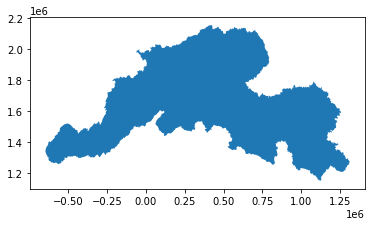

In [4]:
# huc2 vector file
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/yuko_final.shp')
# projected coordinates
shpproj = shp.to_crs(domains[domain]['mod_proj'])
shpproj.plot()

/nfs/attic/dfh/2020_NPRB/data/snotel/YUKO/Station_sites_TOBScelcius_YUKO_2011-10-01_2018-09-30.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


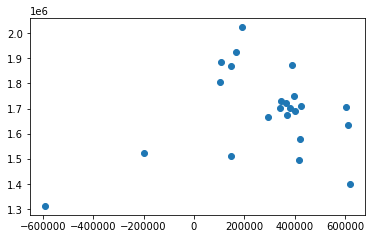

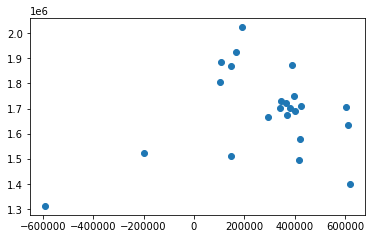

In [8]:
######## TEMP ########
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
# gdf path
gdfpath = dataPath + 'Station_sites_TOBScelcius_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
# open gdf
Tgdf = gpd.read_file(gdfpath)
Tgdf.plot()
#stn data
tdatapath = dataPath + 'Station_data_TOBScelsius_'+st_dt+'_'+ed_dt+'.csv'
# open stn data
t = pd.read_csv(tdatapath,index_col=0)
# clip station in domain bouning box to yuko watershed
stn_clip = gpd.clip(Tgdf, shpproj).reset_index(drop=True)
stn_clip.plot()
# save updated gdf
stn_clip.to_file(gdfpath, driver='GeoJSON')
# select data from stations in domain 
t2 = t[t.columns.intersection(stn_clip.code)]
t2.to_csv(tdatapath)

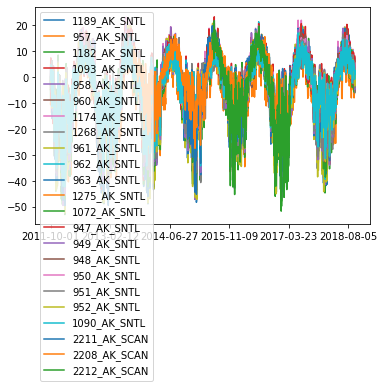

In [20]:
t2.plot()

/nfs/attic/dfh/2020_NPRB/data/snotel/YUKO/Station_sites_PRmeters_YUKO_2011-10-01_2018-09-30.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


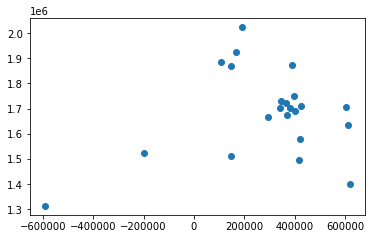

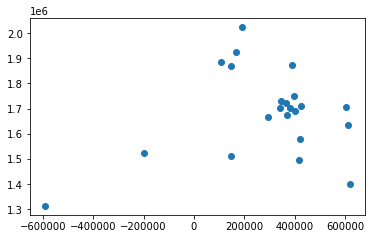

In [9]:
######## PREC ########
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
# gdf path
gdfpath = dataPath + 'Station_sites_PRmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
# open gdf
Pgdf = gpd.read_file(gdfpath)
Pgdf.plot()
#stn data
pdatapath = dataPath + 'Station_data_PRmeters_'+st_dt+'_'+ed_dt+'.csv'
# open stn data
p = pd.read_csv(pdatapath,index_col=0)
# clip station in domain bouning box to yuko watershed
stn_clip = gpd.clip(Pgdf, shpproj).reset_index(drop=True)
stn_clip.plot()
# save updated gdf
stn_clip.to_file(gdfpath, driver='GeoJSON')
# select data from stations in domain 
p2 = p[p.columns.intersection(stn_clip.code)]
p2.to_csv(pdatapath)

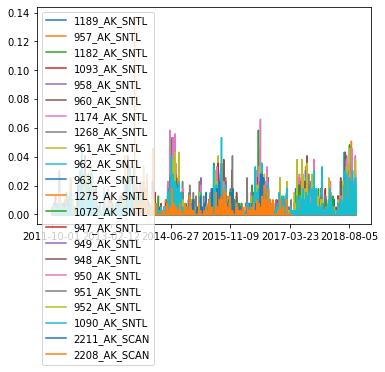

In [12]:
p2.plot()

/nfs/attic/dfh/2020_NPRB/data/snotel/YUKO/Station_sites_SWEDmeters_YUKO_2011-10-01_2018-09-30.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


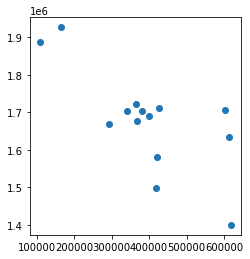

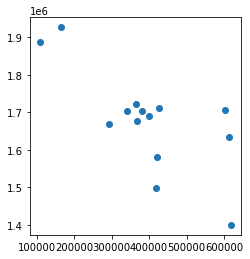

In [10]:
######## SWED ########
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'
# gdf path
gdfpath = dataPath + 'Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson'
# open gdf
Sgdf = gpd.read_file(gdfpath)
Sgdf.plot()
#stn data
sdatapath = dataPath + 'Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
# open stn data
s = pd.read_csv(sdatapath,index_col=0)
# clip station in domain bouning box to yuko watershed
stn_clip = gpd.clip(Sgdf, shpproj).reset_index(drop=True)
stn_clip.plot()
# save updated gdf
stn_clip.to_file(gdfpath, driver='GeoJSON')
# select data from stations in domain 
s2 = s[s.columns.intersection(stn_clip.code)]
s2.to_csv(sdatapath)

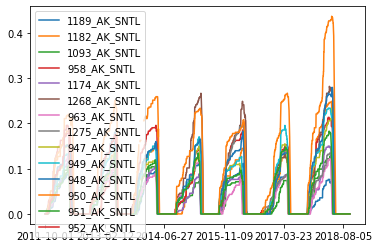

In [11]:
s2.plot()